# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import *
from keras.layers import *
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')

# Load data Of Images 

In [2]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])

In [3]:
df = pd.read_csv("archive (21)/labels.csv")

In [4]:
df.head()

id  count
0   1     35
1   2     41
2   3     41
3   4     44
4   5     41

In [5]:
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [6]:
df.head()

id  count      image_name
0   1     35  seq_000001.jpg
1   2     41  seq_000002.jpg
2   3     41  seq_000003.jpg
3   4     44  seq_000004.jpg
4   5     41  seq_000005.jpg

In [7]:
# Setup some constants
size = 224
batch_size = 64

# Dealing With Images With ImageDataGenerator

In [8]:
# ImageDataGenerator - with defined augmentaions
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixels to [0,1]. This seems to work well with pretrained models.
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=True,  # apply ZCA whitening
#     rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.2, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    validation_split=0.2,  # 20% of data randomly assigned to validation
    
    # This one is important:
    preprocessing_function=resnet50.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

C:\Python310\lib\site-packages\keras\preprocessing\image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


# Import Images From Directory

In [9]:
flow_params = dict(
    dataframe=df,
    directory='archive (21)/frames/frames',
    x_col="image_name",
    y_col="count",
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

# The dataset is split to training and validation sets at this point
train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params    
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)

Found 1600 validated image filenames.
Found 400 validated image filenames.


# Show sample Of images

C:\Python310\lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
C:\Python310\lib\site-packages\keras\preprocessing\image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


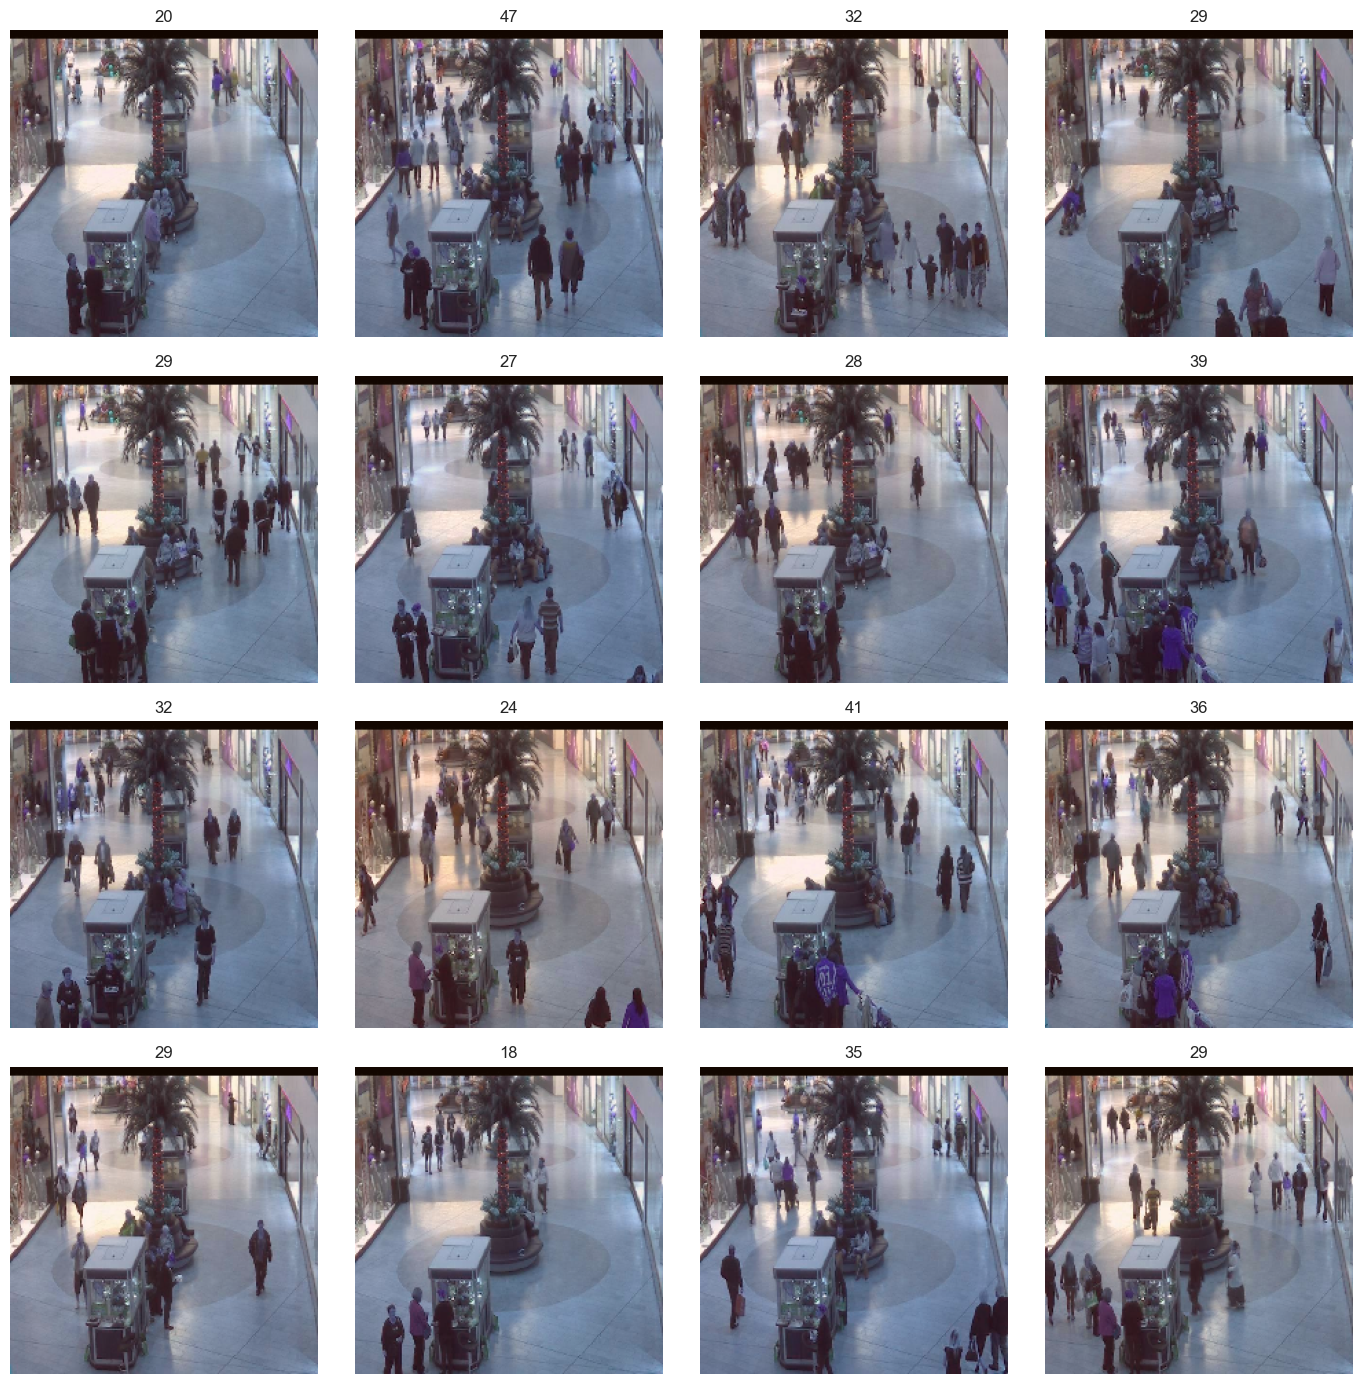

In [10]:
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    image = batch[0][i]
    image = (image - image.min()) / (image.max() - image.min())  # Rescale pixel values to [0, 1]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

# Deploy Model Using Resnet50 Model 

In [11]:
base_model = resnet50.ResNet50(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(size, size, 3),  # 224x224 was the original size ResNet was trained on, so I decided to use this.
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)

In [12]:
# Here we change the top (the last parts) of the network.
x = base_model.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [13]:
model = Model(inputs=base_model.input, outputs=predictions)


In [14]:
k = -7
for layer in model.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [15]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss. 
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [16]:
# Compile the model
model.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [17]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [18]:
# Fit the model
history = model.fit_generator(
    generator=train_generator,
    epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

C:\Users\DELL\AppData\Local\Temp/ipykernel_15140/3470121842.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
25/25 - 144s - loss: 123.7148 - mean_absolute_error: 7.9487 - mean_squared_error: 123.7148 - val_loss: 2621.7039 - val_mean_absolute_error: 50.8937 - val_mean_squared_error: 2621.7039 - lr: 0.0010 - 144s/epoch - 6s/step
Epoch 2/50
25/25 - 141s - loss: 33.9483 - mean_absolute_error: 4.6859 - mean_squared_error: 33.9483 - val_loss: 894.9899 - val_mean_absolute_error: 29.4401 - val_mean_squared_error: 894.9899 - lr: 0.0010 - 141s/epoch - 6s/step
Epoch 3/50
25/25 - 141s - loss: 29.7951 - mean_absolute_error: 4.3851 - mean_squared_error: 29.7951 - val_loss: 464.3325 - val_mean_absolute_error: 20.9128 - val_mean_squared_error: 464.3325 - lr: 0.0010 - 141s/epoch - 6s/step
Epoch 4/50
25/25 - 142s - loss: 28.6538 - mean_absolute_error: 4.3200 - mean_squared_error: 28.6538 - val_loss: 262.4427 - val_mean_absolute_error: 15.3704 - val_mean_squared_error: 262.4427 - lr: 0.0010 - 142s/epoch - 6s/step
Epoch 5/50
25/25 - 141s - loss: 26.9429 - mean_absolute_error: 4.1654 - mean_squared_err

Epoch 36/50
25/25 - 140s - loss: 16.8714 - mean_absolute_error: 3.2592 - mean_squared_error: 16.8714 - val_loss: 15.9422 - val_mean_absolute_error: 3.2175 - val_mean_squared_error: 15.9422 - lr: 1.0000e-06 - 140s/epoch - 6s/step
Epoch 37/50
25/25 - 141s - loss: 16.7322 - mean_absolute_error: 3.2427 - mean_squared_error: 16.7322 - val_loss: 15.9215 - val_mean_absolute_error: 3.2145 - val_mean_squared_error: 15.9215 - lr: 1.0000e-06 - 141s/epoch - 6s/step
Epoch 38/50
25/25 - 140s - loss: 16.9599 - mean_absolute_error: 3.2677 - mean_squared_error: 16.9599 - val_loss: 15.9076 - val_mean_absolute_error: 3.2126 - val_mean_squared_error: 15.9076 - lr: 1.0000e-06 - 140s/epoch - 6s/step
Epoch 39/50
25/25 - 144s - loss: 16.7541 - mean_absolute_error: 3.2367 - mean_squared_error: 16.7541 - val_loss: 15.8905 - val_mean_absolute_error: 3.2104 - val_mean_squared_error: 15.8905 - lr: 1.0000e-06 - 144s/epoch - 6s/step
Epoch 40/50
25/25 - 140s - loss: 16.7235 - mean_absolute_error: 3.2265 - mean_square

# Save Model 

In [19]:
from joblib import Parallel, delayed
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(history, 'CrowdedCountModel.pkl')

['CrowdedCountModel.pkl']

In [57]:
from joblib import Parallel, delayed
import joblib
  
  
# Save the model as a pickle in a file
joblib.dump(model, 'CrowdedCountModel2.pkl')

['CrowdedCountModel2.pkl']

# Model Accuracy visualization 

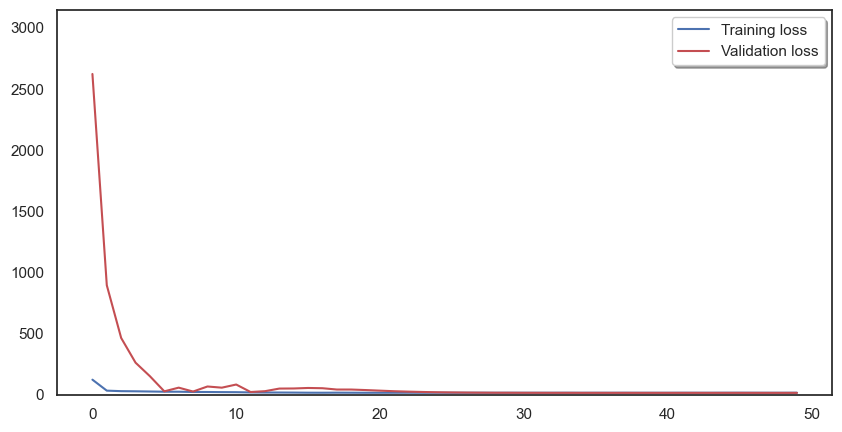

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

In [21]:
valid_generator

In [22]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels = np.concatenate(all_labels)
cat_pred = np.concatenate(all_pred)

1/1 [==============================] - 2s 2s/step


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


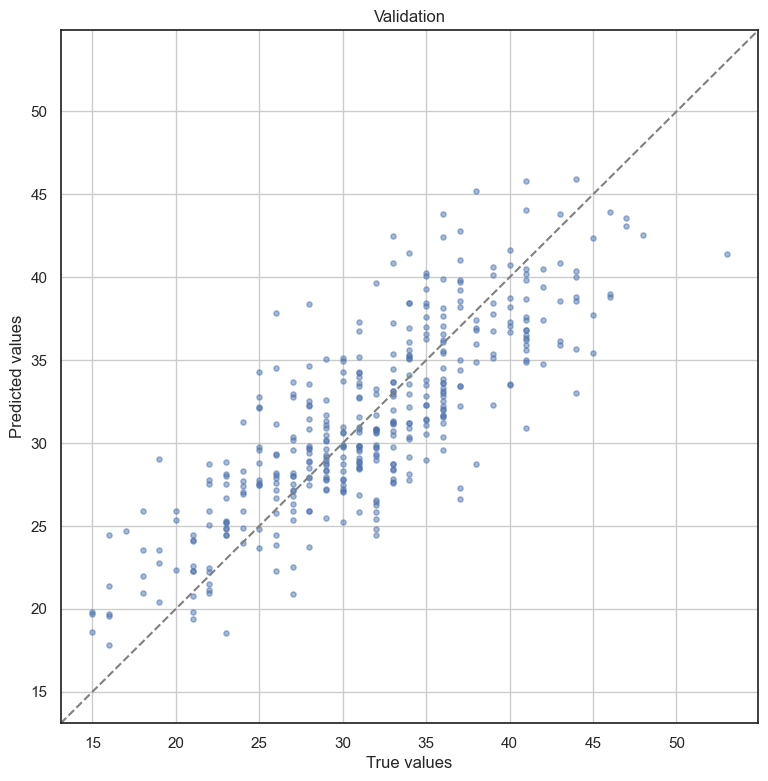

In [23]:
df_predictions = pd.DataFrame({'True values': cat_labels, 'Predicted values': cat_pred})
ax = df_predictions.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

In [24]:
mse = mean_squared_error(*df_predictions.T.values)
pearson_r = sc.stats.pearsonr(*df_predictions.T.values)[0]

print(f'MSE: {mse:.1f}\nPearson r: {pearson_r:.1f}')

MSE: 15.8
Pearson r: 0.8


In [25]:
# import os , random
# import glob as gb
# import cv2
# files = []
# Image_Test_Array = []
# Image_Test_Array_reshaped = []
# for folders in  os.listdir() :
# #     print(folders)
#     if folders == 'test images' :        
#         for f in os.listdir('test images') :
# #                 print (f)
#                 files.append(f)
#                 files = gb.glob(pathname= str('test images'+ '/'+ f))
# #                 print(files)
#                 for file in files:
# #                     print(file)
#                     random.shuffle(files)
#                     image = cv2.imread(file)
#                     image.shape
# #                     print(image)
#                     image_array = cv2.resize(image , (size,size))
#                     img = image_array.reshape(1,size,size,3)
#                     Image_Test_Array.append(image_array)
#                     Image_Test_Array_reshaped.append(img)

# #                     X_train.append(list(image_array))
# #                     y_train.append(rock_code[f])

# Predict Mall Images 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 1s/step


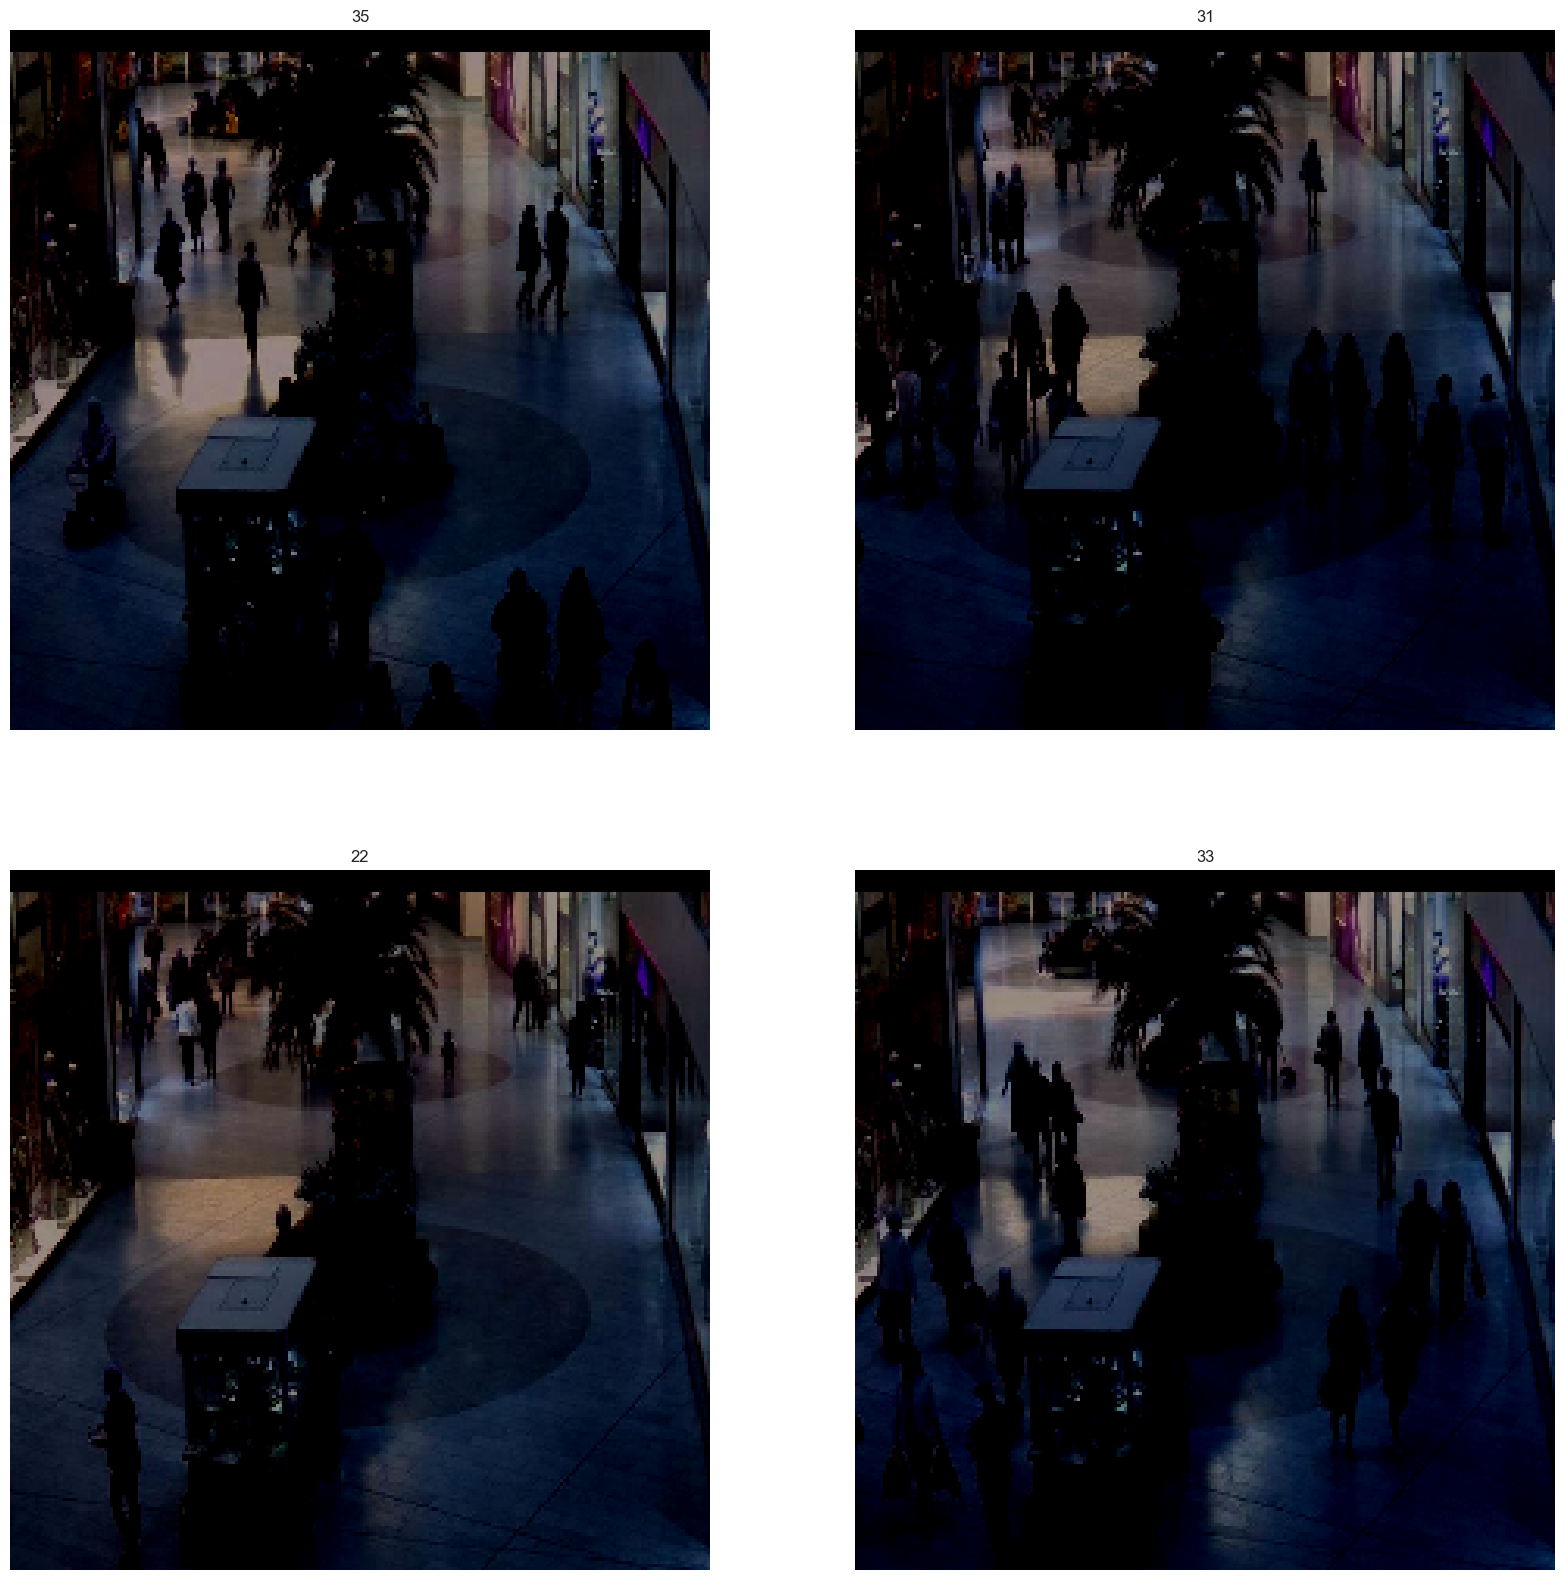

In [26]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x[0]),4))) : 
    plt.subplot(2,2,n+1)
    plt.imshow(x[0][i])   
    plt.axis('off')
    plt.title(int(model.predict(x[0])[i]))

# Test New DataSet

In [27]:

# ImageDataGenerator - with defined augmentaions
datagen_test = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixels to [0,1]. This seems to work well with pretrained models.
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
#     rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.2, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,    
    # This one is important:
    preprocessing_function=resnet50.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

In [28]:
directory = 'C:/Upwork/crowed detection/test images/'

In [50]:
test_Data = datagen_test.flow_from_directory(
    directory,
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='jpg',
    follow_links=False,
    subset=None,
    interpolation='nearest',
    keep_aspect_ratio=False
)


Found 7 images belonging to 2 classes.


In [51]:
test_Data

In [53]:
len(test_Data[0][0])

7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 1s/step


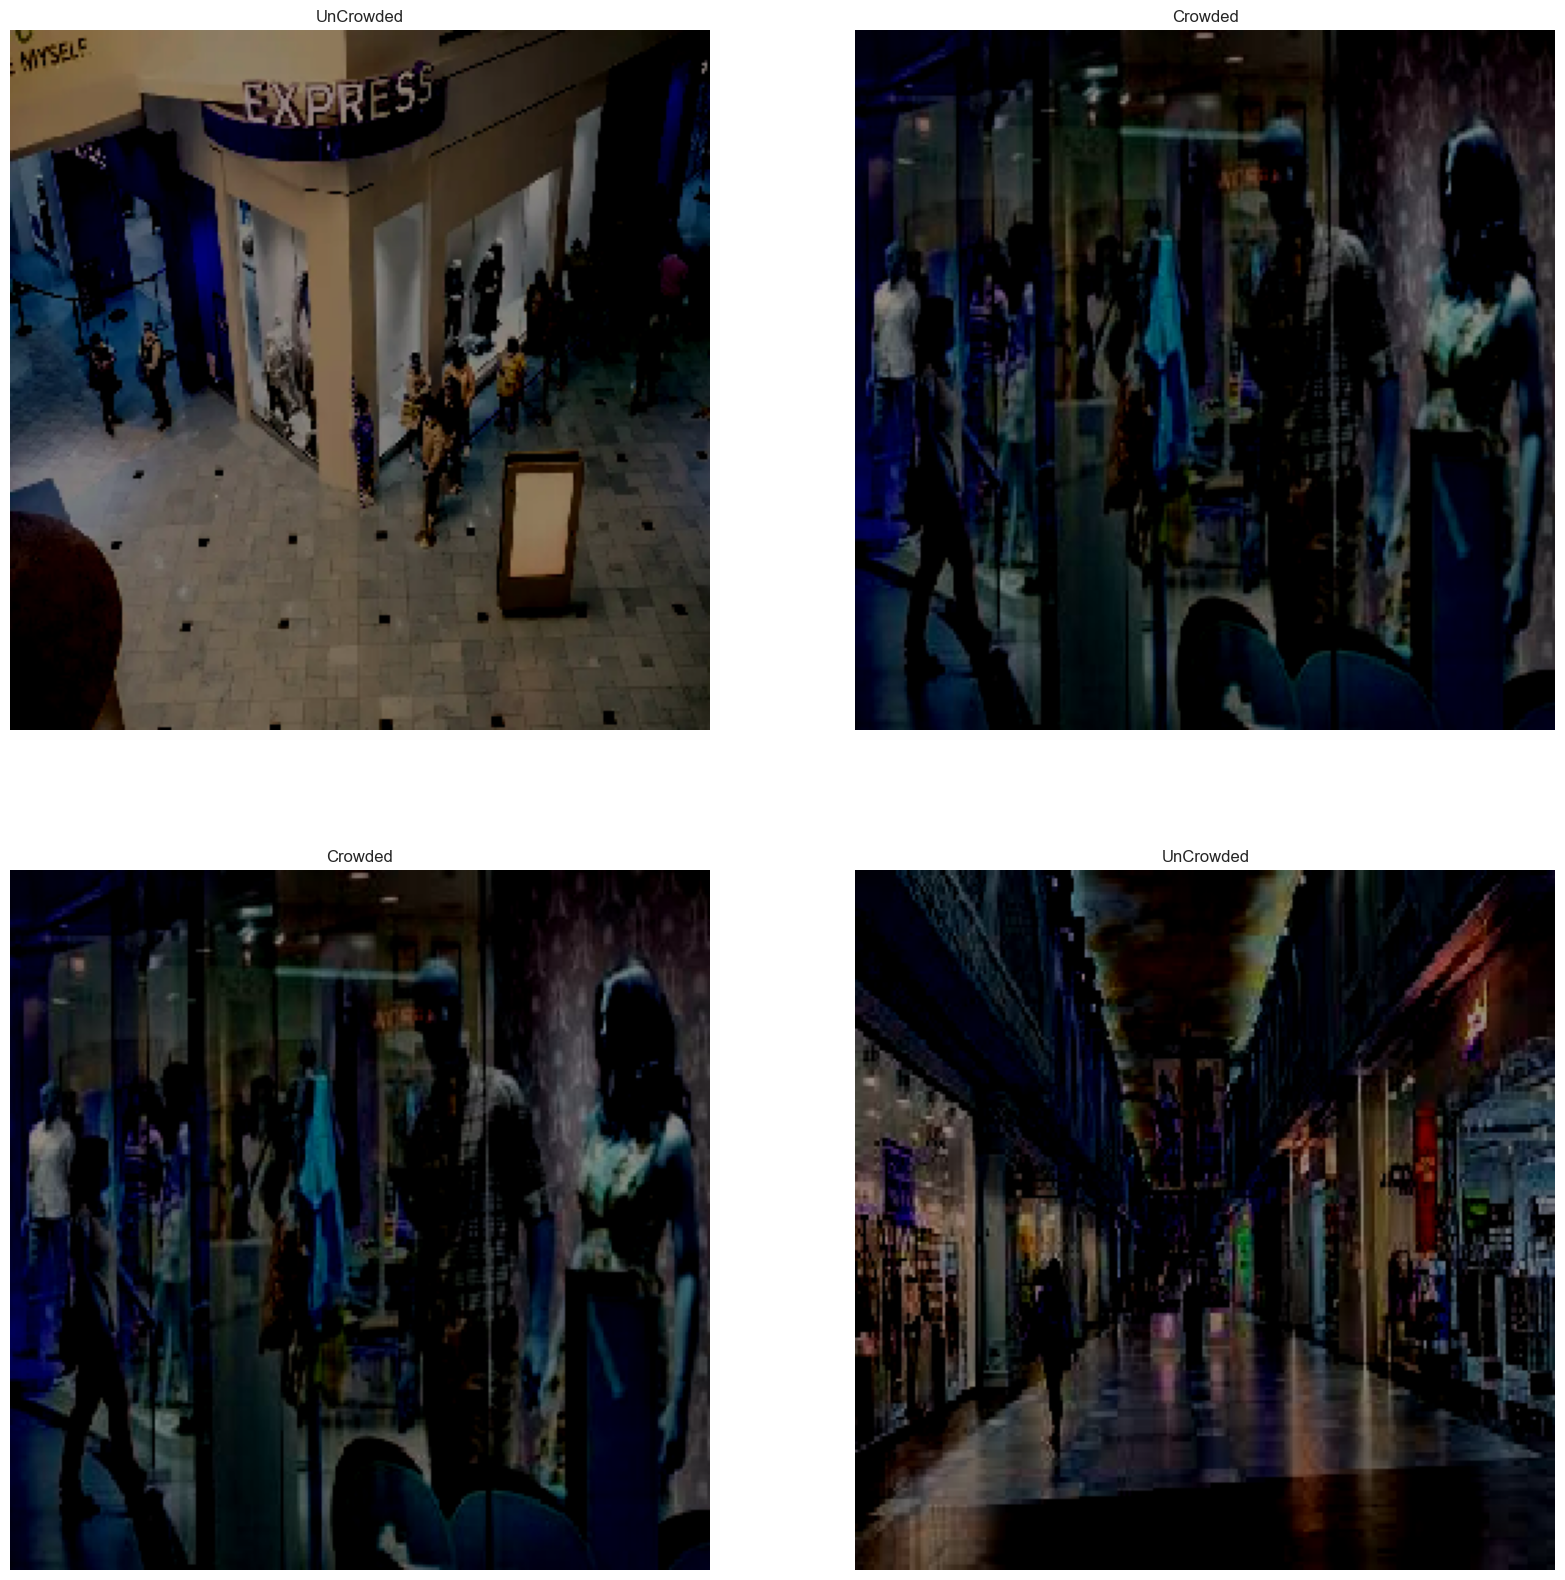

In [56]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(test_Data[0][0]),4))) : 
    plt.subplot(2,2,n+1)
    plt.imshow(test_Data[0][0][i])   
    plt.axis('off')
    predection = int(model.predict(test_Data[0][0])[i]) 
    plt.title("Crowded" if predection > 40 else "UnCrowded")